In [6]:
!nvidia-smi

Sat Feb 11 00:09:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0    26W /  N/A |   5280MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!pip install gdown
!pip install tensorflow-gpu

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\hp\AppData\Local\Temp\pip-install-yuzdly_i\tensorflow-gpu_0981136d98114025907940311b90faaf\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not ru

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [12]:
#!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
#!tar -xvf WISDM_ar_latest.tar.gz

In [36]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.sb.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

ParserError: Error tokenizing data. C error: Expected 6 fields in line 832907, saw 7


In [0]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [0]:
df.shape

(1098203, 6)

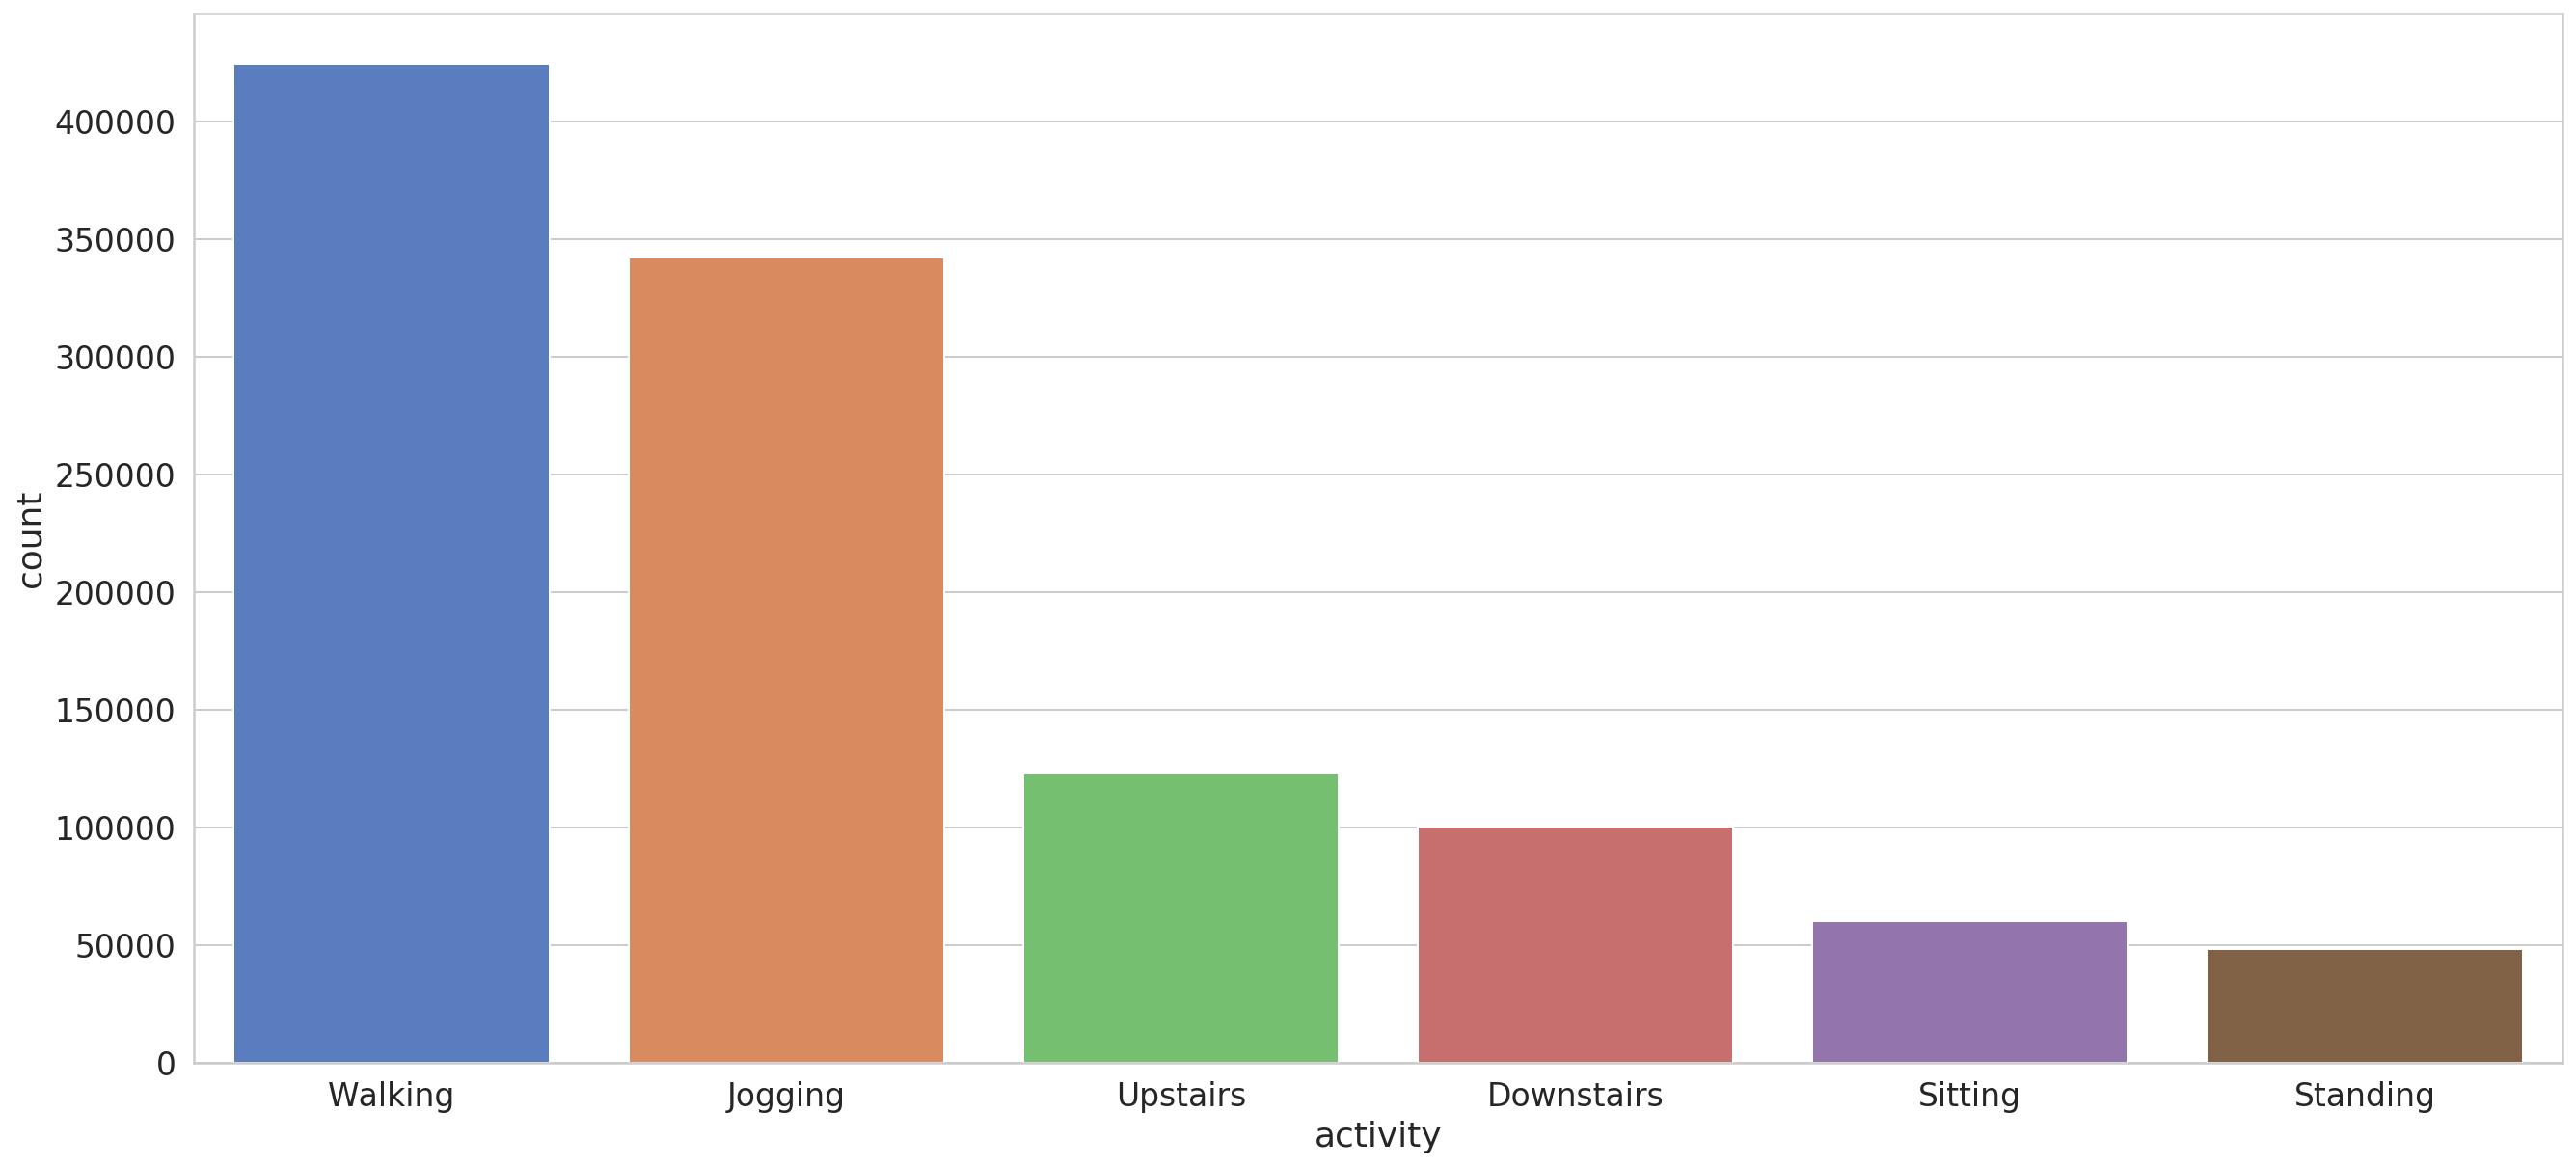

In [0]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);

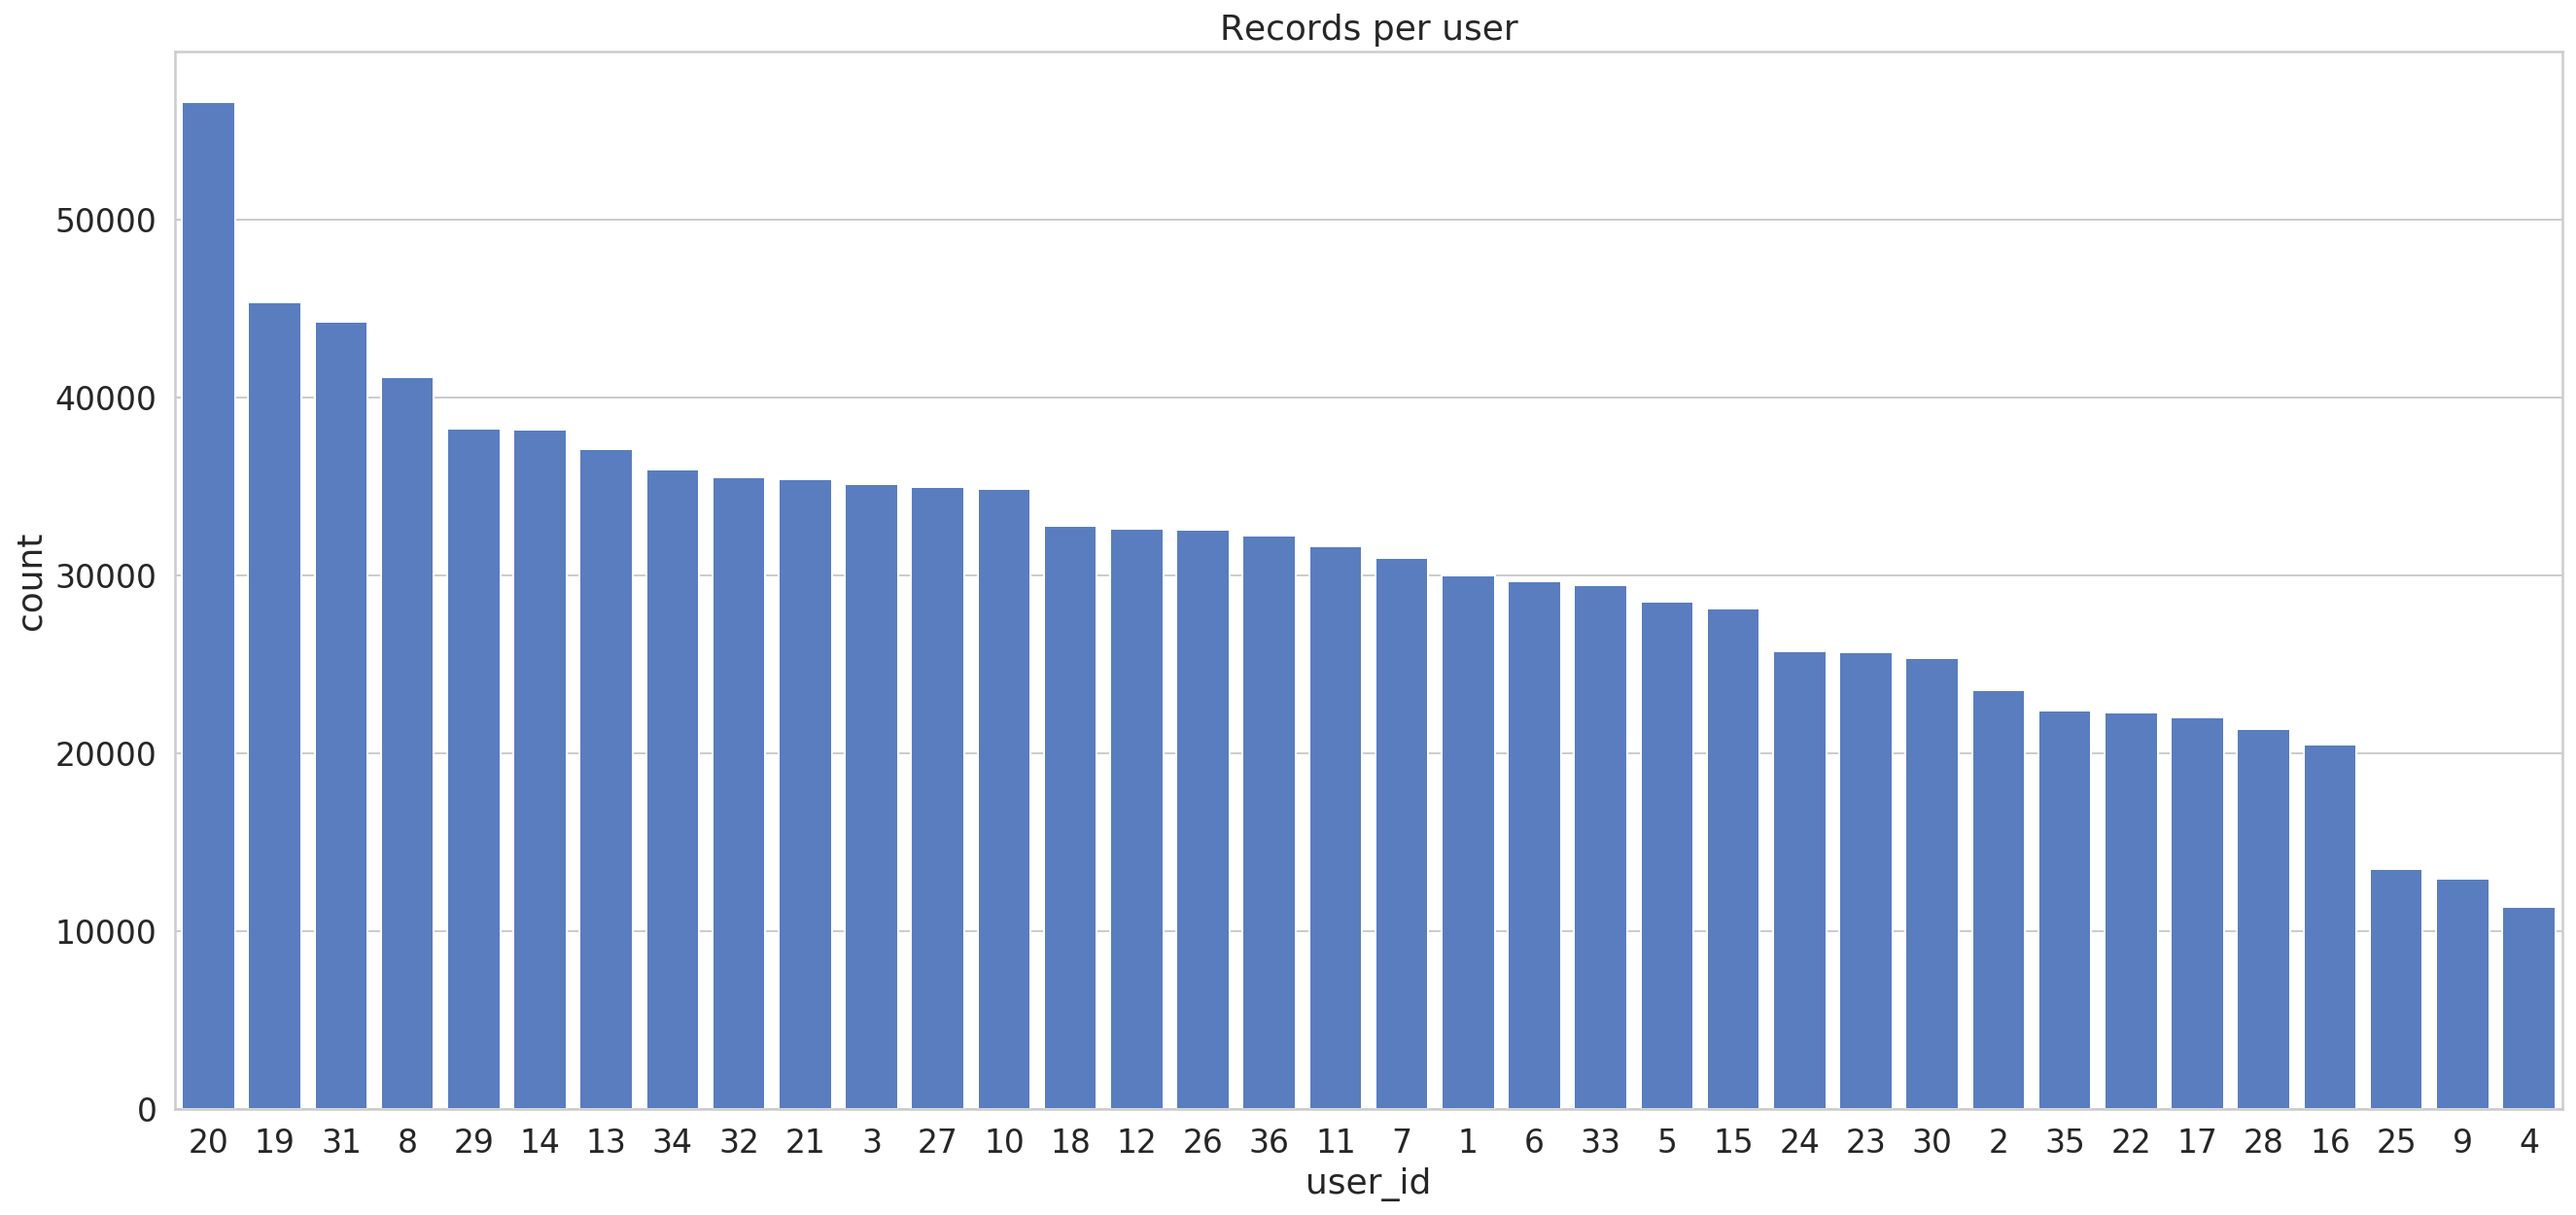

In [0]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [3]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [4]:
plot_activity("Sitting", df);

NameError: name 'df' is not defined

In [5]:
plot_activity("Jogging", df);

NameError: name 'df' is not defined

In [0]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [0]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [2]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

NameError: name 'df_train' is not defined

In [0]:
print(X_train.shape, y_train.shape)

(22454, 200, 3) (22454, 1)


In [0]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [1]:
print(X_train.shape, y_train.shape)
print(X_train)

NameError: name 'X_train' is not defined

In [0]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

Train on 20208 samples, validate on 2246 samples
Epoch 1/20
20208/20208 [==============================] - 229s 11ms/sample - loss: 1.0116 - acc: 0.6550 - val_loss: 0.8067 - val_acc: 0.7471
Epoch 2/20
20208/20208 [==============================] - 229s 11ms/sample - loss: 0.6785 - acc: 0.7595 - val_loss: 0.6865 - val_acc: 0.7783
Epoch 3/20
20208/20208 [==============================] - 226s 11ms/sample - loss: 0.5842 - acc: 0.7900 - val_loss: 0.5044 - val_acc: 0.8402
Epoch 4/20
20208/20208 [==============================] - 226s 11ms/sample - loss: 0.4848 - acc: 0.8201 - val_loss: 0.6837 - val_acc: 0.8228
Epoch 5/20
20208/20208 [==============================] - 229s 11ms/sample - loss: 0.4291 - acc: 0.8410 - val_loss: 0.4128 - val_acc: 0.8549
Epoch 6/20
20208/20208 [==============================] - 226s 11ms/sample - loss: 0.3836 - acc: 0.8588 - val_loss: 0.3750 - val_acc: 0.8664
Epoch 7/20
20208/20208 [==============================] - 226s 11ms/sample - loss: 0.3014 - acc: 0.8899 -

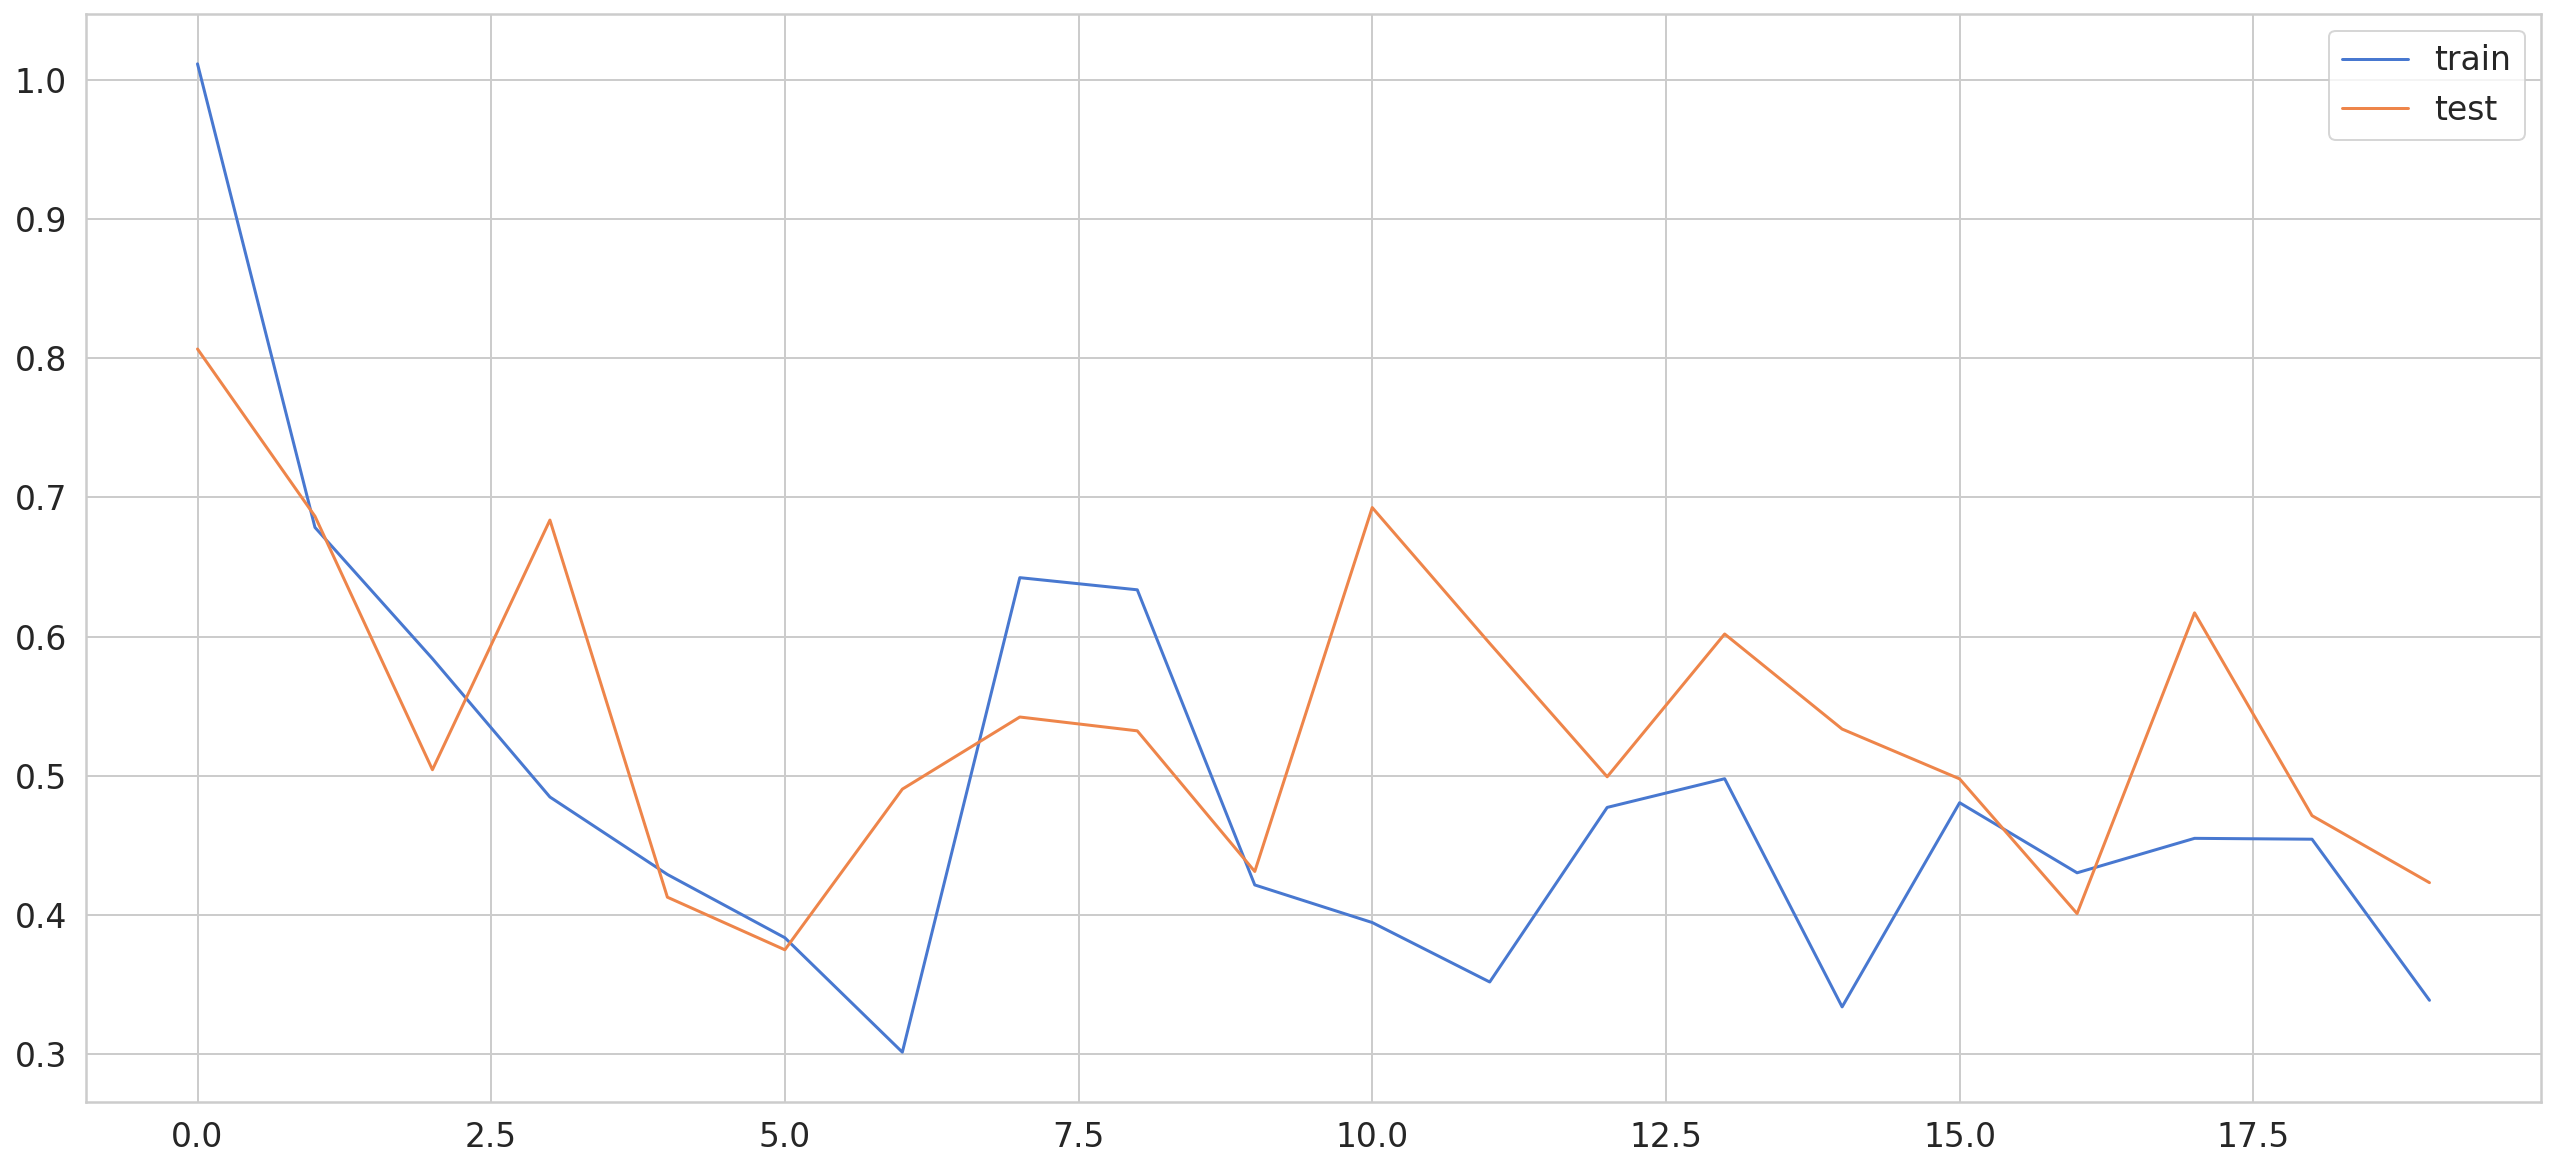

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [0]:
model.evaluate(X_test, y_test)

4992/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3619675412960649, 0.8790064]

In [0]:
y_pred = model.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

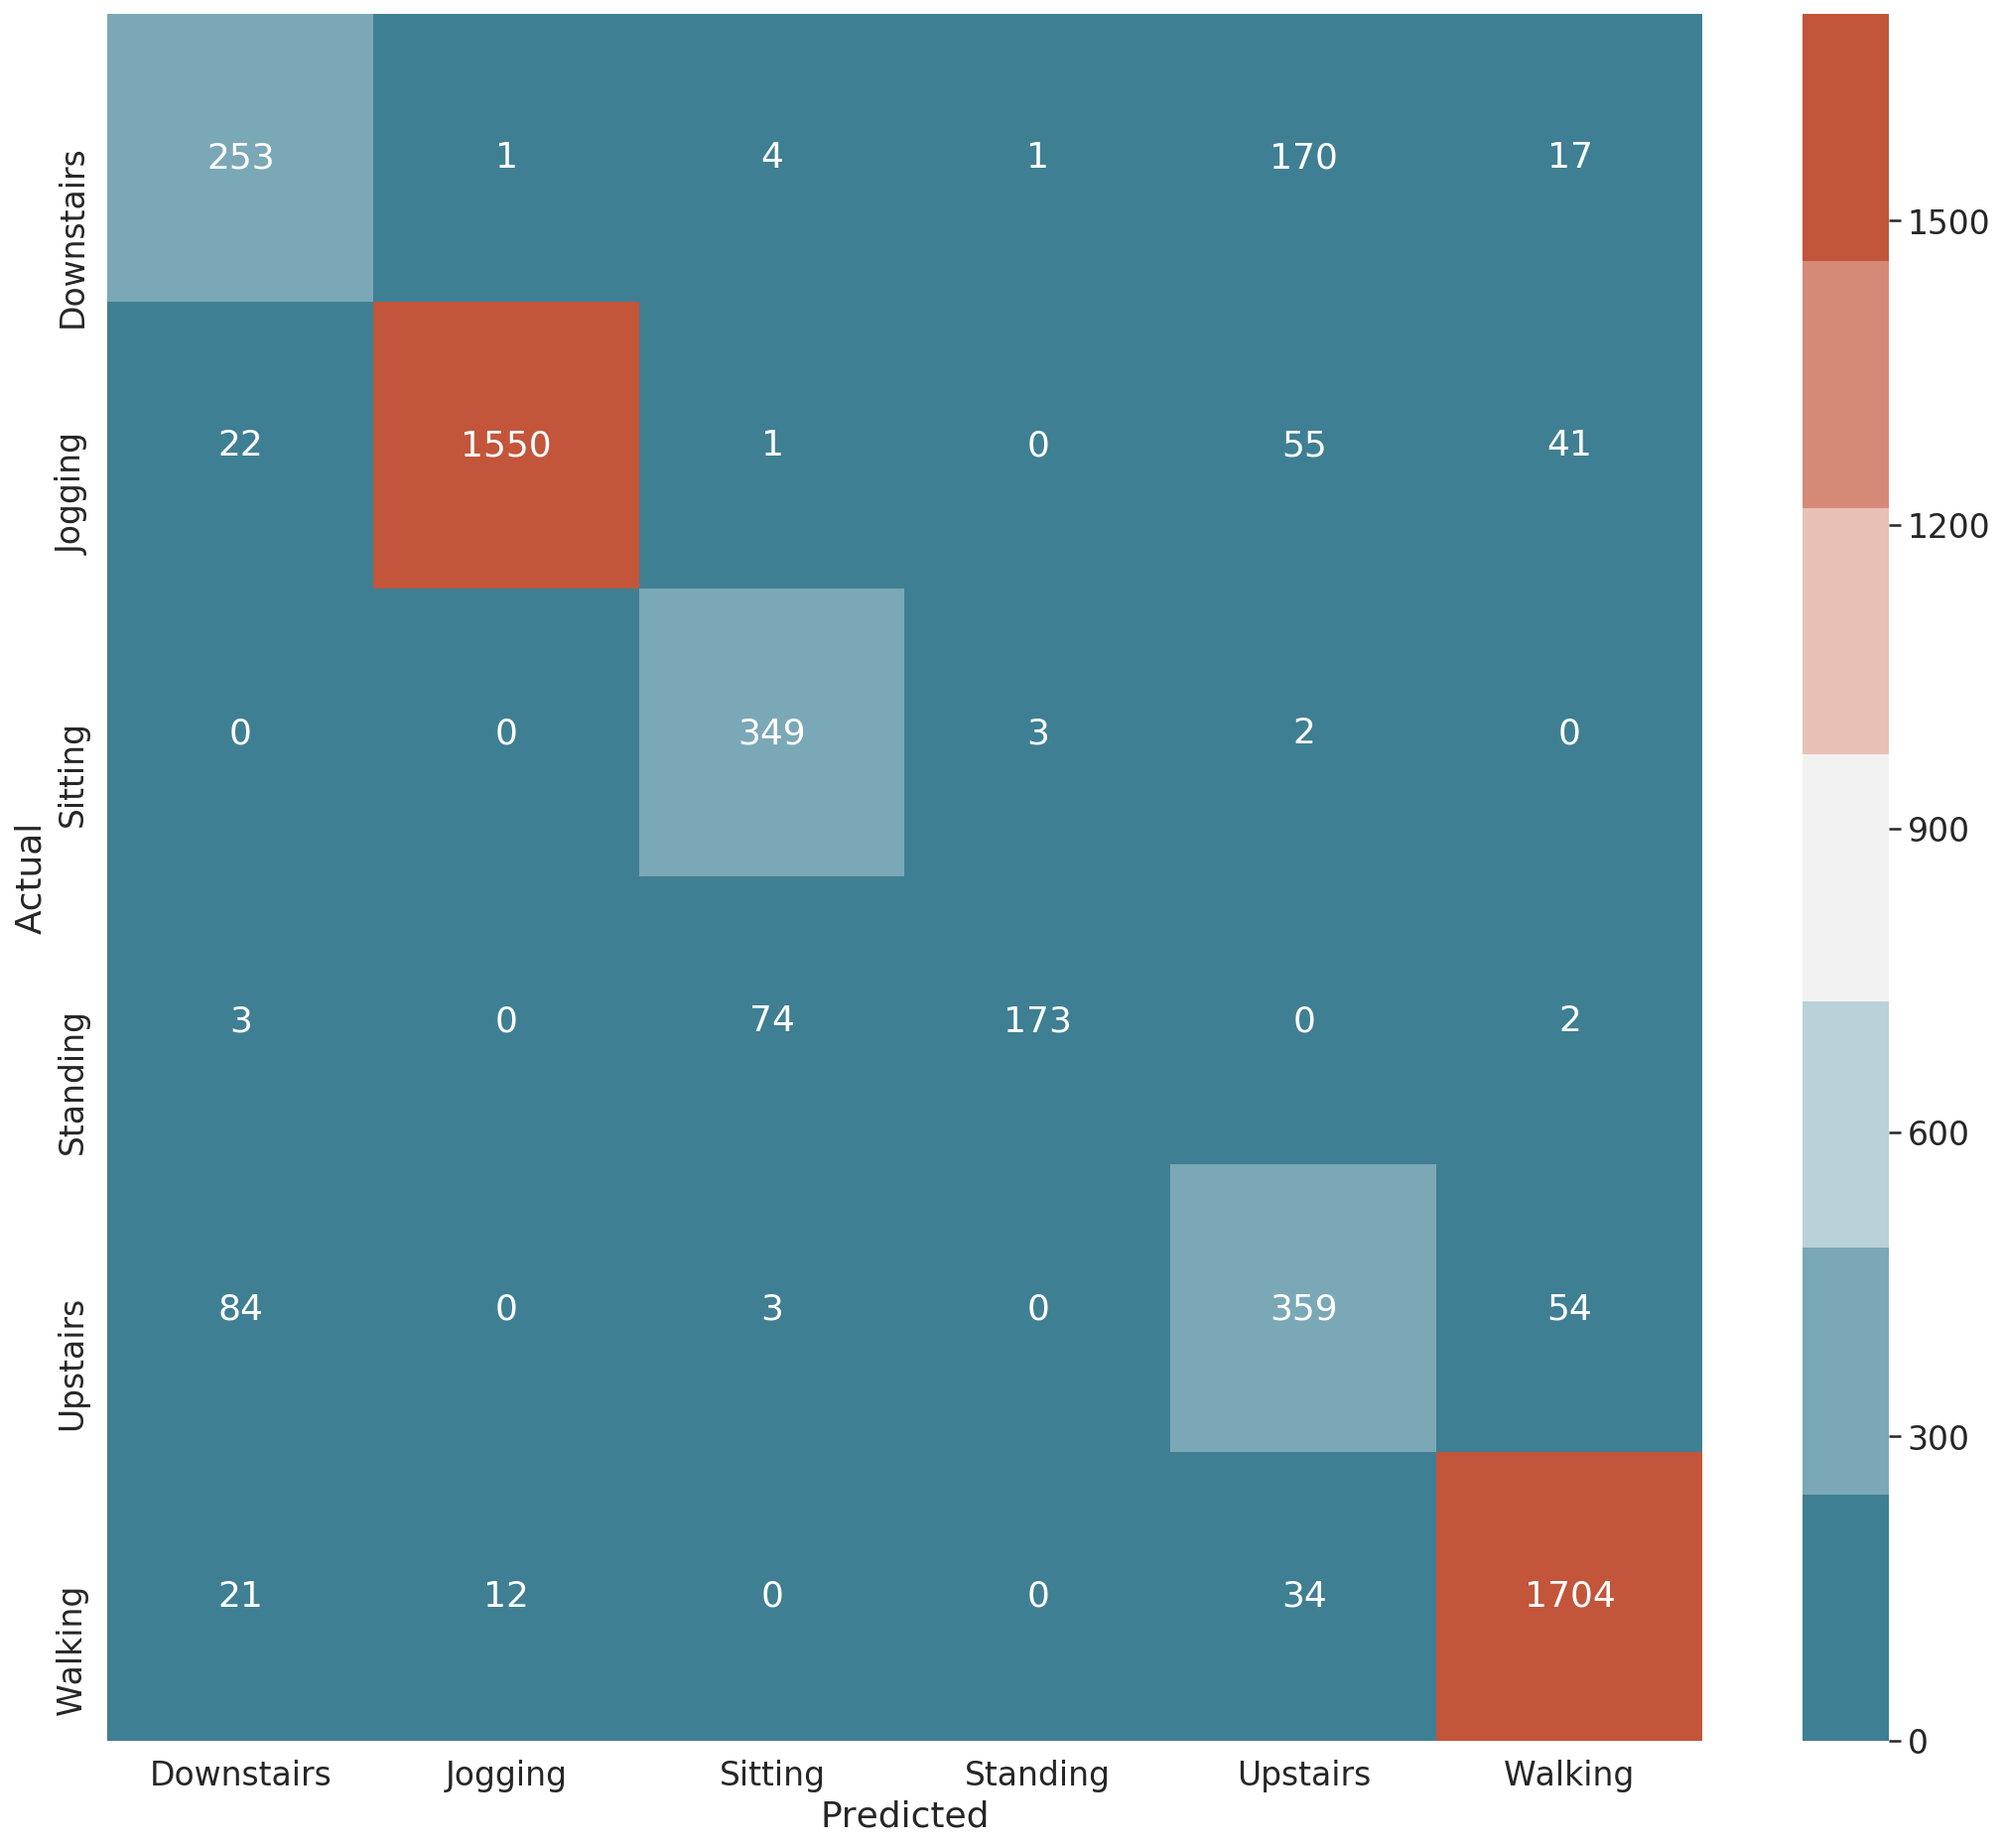

In [0]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)